In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in `{models_path}/{run_num}/metrics.json` and returns the contents as a
    Python dictionary. Returns None if the path does not exist, or if the JSON is
    malformed.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        print("Path does not exist: %s" % path)
        return None
    try:
        with open(path, "r") as f:
            return json.load(f)
    except json.JSONDecodeError:
        print("Malformed JSON: %s" % path)
        return None

In [3]:
def import_all_metrics_json(models_path):
    """
    Looks in `models_path` and finds all instances of
    `{models_path}/{run_num}/metrics.json`, returning a dictionary that maps
    `{run_num}` to the metrics dictionary.
    """
    all_metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path) if run_num != "_sources"}
    all_metrics = {key : val for key, val in all_metrics.items() if val}  # Remove empties
    return all_metrics

In [4]:
def extract_metrics_values(metrics, key):
    """
    From a single metrics dictionary (i.e. the imported metrics.json for a
    single run), extracts the set of values with the given key.
    """
    return metrics[key]["values"]

In [5]:
def extract_best_run_epoch(all_metrics):
    """
    From a metrics dictionary of all runs (i.e. the imported metrics from
    `import_all_metrics_json`, determines the best run and epoch, which got
    the lowest validation loss.
    Returns the best run, best epoch (1-indexed), and the validation loss.
    """
    val_key = "val_epoch_loss"
    best_run, best_epoch, best_val = None, None, None
    for run in all_metrics:
        metrics = all_metrics[run]
        vals = extract_metrics_values(metrics, val_key)
        epoch = np.argmin(vals)
        val = vals[epoch]
        if best_val is None or val < best_val:
            best_run, best_epoch, best_val = run, epoch + 1, val
    return best_run, best_epoch, best_val

In [6]:
# For each TF and each fold, find the best model in terms of validation loss
# and record its test profile NLL and count correlation
tfs = ["CEBPB", "E2F6", "GABPA", "JUND", "REST", "SPI1", "NR3C1", "NR3C1-reddytime", "FOXA2", "MAFK", "MAX"]

prof_nlls, count_corrs = {}, {} # TF -> Fold -> list of values in best epoch over the runs
best_runs_epochs = {}  # TF -> Fold -> (best run, best epoch, best validation loss)

for tf in tfs:
    print("Fetching data for %s" % tf)
    prof_nlls[tf], count_corrs[tf] = {}, {}
    best_runs_epochs[tf] = {}
    for fold_num in range(1, 11):
        condition = "%s_fold%d" % (tf, fold_num)
        models_path = "/users/amtseng/tfmodisco/models/trained_models/%s/" % condition
        
        all_metrics = import_all_metrics_json(models_path)
        best_run, best_epoch, best_val = extract_best_run_epoch(all_metrics)
        best_runs_epochs[tf][fold_num] = (best_run, best_epoch, best_val)
        
        prof_nlls[tf][fold_num], count_corrs[tf][fold_num] = [], []
        for run_num in sorted(all_metrics.keys(), key=lambda s: int(s)):
            metrics = import_metrics_json(models_path, run_num)
            try:
                prof_nlls[tf][fold_num].append(np.mean(metrics["summit_prof_nll"]["values"]))
                count_corrs[tf][fold_num].append(np.mean(metrics["summit_count_pearson"]["values"]))
            except KeyError:
                print("\tFailed on F%dR%s" % (fold_num, run_num))

Fetching data for CEBPB
Fetching data for E2F6
Fetching data for GABPA
Fetching data for JUND
Fetching data for REST
Fetching data for SPI1
Fetching data for NR3C1
Fetching data for NR3C1-reddytime
	Failed on F4R2
Fetching data for FOXA2
Fetching data for MAFK
Fetching data for MAX


In [7]:
# Print out best runs/epochs for each folds
print("Best runs/epochs in each fold")
for tf in tfs:
    tf_runs_epochs = best_runs_epochs[tf]
    print(tf)
    print("Fold\tRun\tEpoch\tValidation loss")
    for fold_num in sorted(tf_runs_epochs.keys()):
        print("%d\t%s\t%s\t%.3f" % ((fold_num,) + tf_runs_epochs[fold_num]))
    print()

Best runs/epochs in each fold
CEBPB
Fold	Run	Epoch	Validation loss
1	1	3	153.417
2	1	5	154.314
3	2	4	161.685
4	1	5	146.604
5	3	5	142.914
6	2	5	149.773
7	2	6	137.989
8	3	4	142.446
9	3	4	146.609
10	1	5	148.111

E2F6
Fold	Run	Epoch	Validation loss
1	2	2	267.874
2	3	3	297.518
3	3	5	282.232
4	2	8	225.094
5	2	7	252.673
6	3	4	252.569
7	3	5	260.351
8	2	9	238.342
9	2	8	226.818
10	3	4	243.694

GABPA
Fold	Run	Epoch	Validation loss
1	3	8	218.935
2	3	4	232.585
3	1	3	255.194
4	2	4	237.052
5	2	5	226.916
6	1	6	242.990
7	1	6	215.970
8	2	6	224.744
9	1	5	244.437
10	1	5	231.991

JUND
Fold	Run	Epoch	Validation loss
1	3	5	150.429
2	1	3	157.094
3	3	2	151.109
4	2	5	153.465
5	3	1	146.343
6	2	2	148.633
7	1	2	138.091
8	3	4	146.102
9	1	2	160.832
10	2	2	155.221

REST
Fold	Run	Epoch	Validation loss
1	1	5	194.040
2	3	4	199.477
3	3	4	213.130
4	1	3	205.565
5	1	4	182.131
6	2	3	207.681
7	1	4	179.817
8	2	4	187.599
9	1	3	201.389
10	1	5	193.597

SPI1
Fold	Run	Epoch	Validation loss
1	1	8	237.290
2	1	9	163.287
3	3	7	162.039


In [8]:
# Print out best runs/epochs over all folds
print("Best runs/epochs over all folds")
print("TF\tFold\tRun\tEpoch\tValidation loss")
for tf in tfs:
    tf_runs_epochs = best_runs_epochs[tf]
    best_fold, best_val_loss = None, None
    for fold_num in sorted(tf_runs_epochs.keys()):
        val_loss = tf_runs_epochs[fold_num][2]
        if best_fold is None or val_loss < best_val_loss:
            best_fold, best_val_loss = fold_num, val_loss
    print("%s\t%d\t%s\t%s\t%.3f" % ((tf, best_fold) + tf_runs_epochs[best_fold]))

Best runs/epochs over all folds
TF	Fold	Run	Epoch	Validation loss
CEBPB	7	2	6	137.989
E2F6	4	2	8	225.094
GABPA	7	1	6	215.970
JUND	7	1	2	138.091
REST	7	1	4	179.817
SPI1	7	3	9	155.297
NR3C1	6	2	10	187.504
NR3C1-reddytime	5	2	4	147.582
FOXA2	7	2	4	202.129
MAFK	8	2	7	166.660
MAX	1	3	5	162.922


In [9]:
def plot_fold_consistency(tf_data_dict, ylabel):
    fig, ax = plt.subplots(len(tfs), 1, figsize=(10, 20), sharex=True, sharey=True)
    for i, tf in enumerate(tfs):
        xvals, yvals = [], []
        for fold_num, vals in tf_data_dict[tf].items():
            xvals.extend([fold_num] * len(vals))
            yvals.extend(vals)
        ax[i].scatter(xvals, yvals)
        ax[i].set_title(tf, fontsize=16)
    plt.xlabel("Fold", fontsize=14)
    plt.xticks(range(1, 11))
    fig.text(0.06, 0.5, ylabel, ha="center", va="center", rotation="vertical", fontsize=14)
    fig.suptitle("Consistency of " + ylabel + " across folds", fontsize=16)

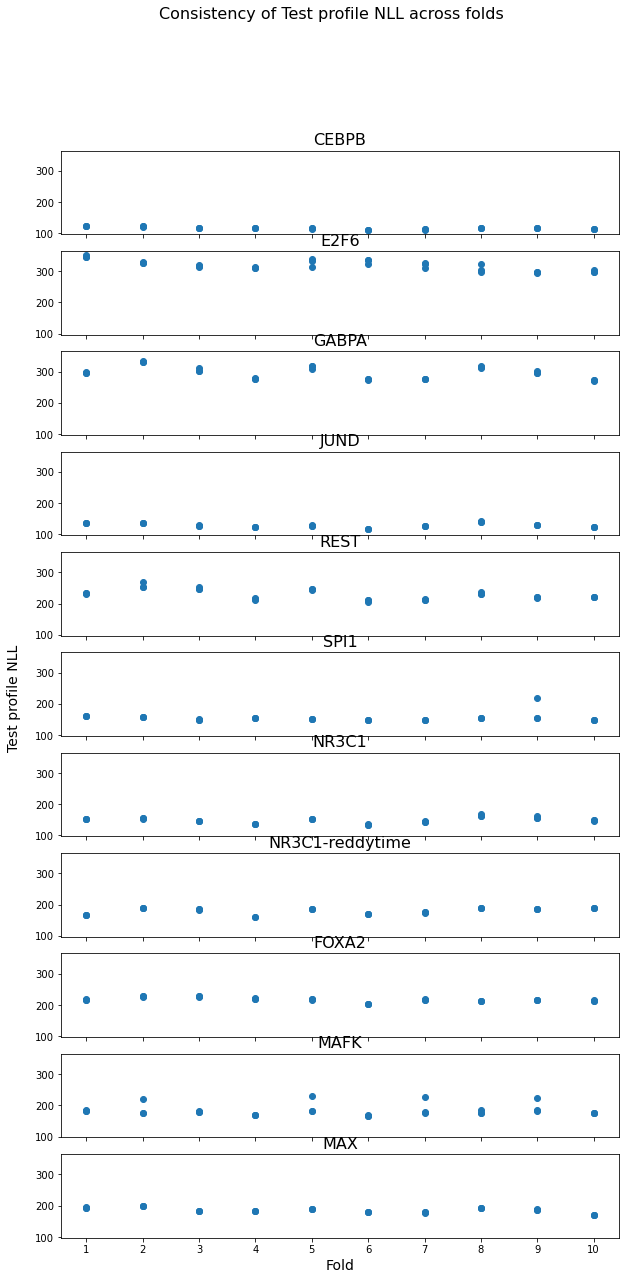

In [10]:
plot_fold_consistency(prof_nlls, "Test profile NLL")

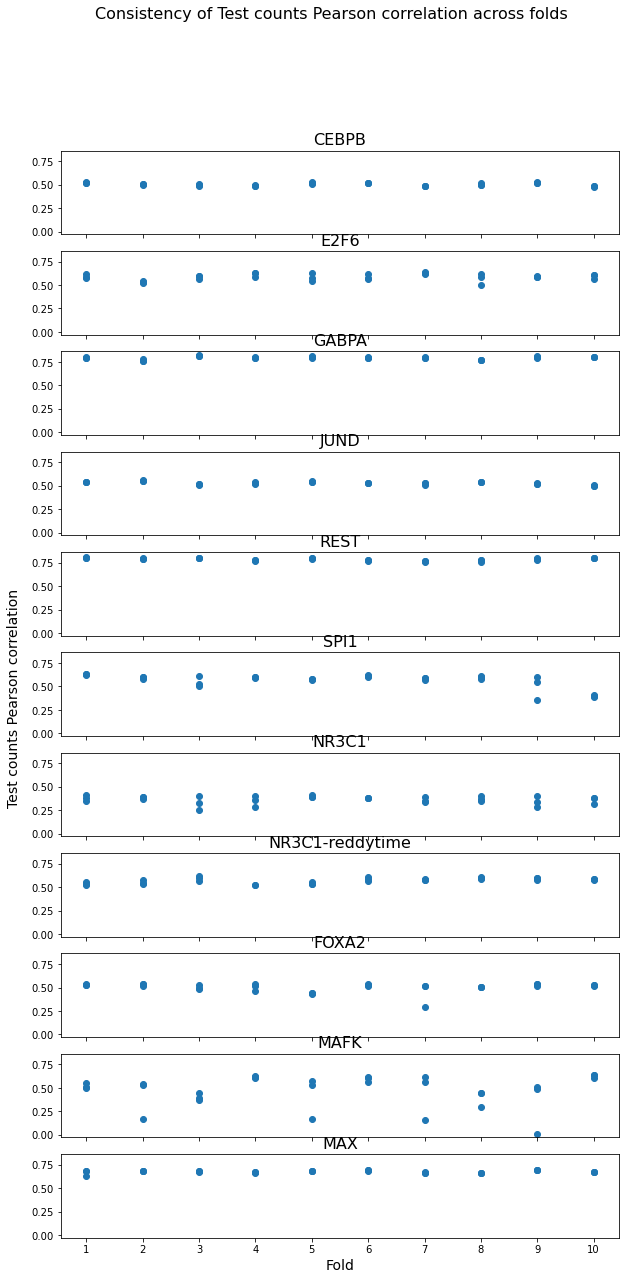

In [11]:
plot_fold_consistency(count_corrs, "Test counts Pearson correlation")